In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_validate, train_test_split, cross_val_score)
from sklearn.metrics import make_scorer,recall_score, roc_auc_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from scipy.stats import skew, kurtosis

from time import time
import warnings
plt.rc('font', family='NanumGothic')
warnings.filterwarnings('ignore')

In [102]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')
# df_train = df_train.drop('id', axis=1)
# df_test = df_test.drop('id', axis=1)

df_train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


n = 42100

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          42100 non-null  int64  
 1   no_of_children                        42100 non-null  int64  
 2   no_of_weekend_nights                  42100 non-null  int64  
 3   no_of_week_nights                     42100 non-null  int64  
 4   type_of_meal_plan                     42100 non-null  int64  
 5   required_car_parking_space            42100 non-null  int64  
 6   room_type_reserved                    42100 non-null  int64  
 7   lead_time                             42100 non-null  int64  
 8   arrival_year                          42100 non-null  int64  
 9   arrival_month                         42100 non-null  int64  
 10  arrival_date                          42100 non-null  int64  
 11  market_segment_

# Features info

# Info

결측치는 없음

In [104]:
print('# df_train')
print(df_train.isna().sum())
print('# df_test')
print(df_test.isna().sum())

# df_train
id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64
# df_test
id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0


중복 데이터 다수 존재  
중복 데이터 삭제

In [114]:
df_train.iloc[:,:-1]

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2
42096,42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0
42097,42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0
42098,42098,1,0,0,3,0,0,0,5,2018,11,9,0,0,0,0,120.00,0


In [103]:
# target data인 booking_status를 제외한 column 기준
print('# df_train', df_train.iloc[:,:-1].duplicated().sum())
print('# df_test', df_test.duplicated().sum())

# df_train 0
# df_test 0


In [27]:
df_train = df_train.drop_duplicates(df_train.columns[:-1])
df_test = df_test.drop_duplicates()
print('# df_train', df_train.iloc[:,:-1].duplicated().sum())
print('# df_test', df_test.duplicated().sum())

# df_train 0
# df_test 0


# EDA

In [31]:
df_train.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [29]:
for column in df_train.columns:
    print('#', column)
    print(df_train[column].value_counts())

# no_of_adults
2    30318
1     6988
3     4053
0      167
4       12
Name: no_of_adults, dtype: int64
# no_of_children
0    37230
1     2724
2     1560
3       17
4        5
9        2
Name: no_of_children, dtype: int64
# no_of_weekend_nights
0    17857
2    12019
1    11233
3      237
4      128
5       46
6       17
7        1
Name: no_of_weekend_nights, dtype: int64
# no_of_week_nights
2     12698
3     10141
1      9413
4      4133
5      2569
0      1920
6       237
7       159
8        83
10       82
9        53
11       16
15       11
12        9
13        5
16        4
14        3
17        2
Name: no_of_week_nights, dtype: int64
# type_of_meal_plan
0    35030
2     3313
1     3189
3        6
Name: type_of_meal_plan, dtype: int64
# required_car_parking_space
0    40476
1     1062
Name: required_car_parking_space, dtype: int64
# room_type_reserved
0    29321
1     9111
3     1464
2     1128
4      318
5      190
6        6
Name: room_type_reserved, dtype: int64
# lead_time
1   

### booking_status(target)

<AxesSubplot:xlabel='booking_status', ylabel='count'>

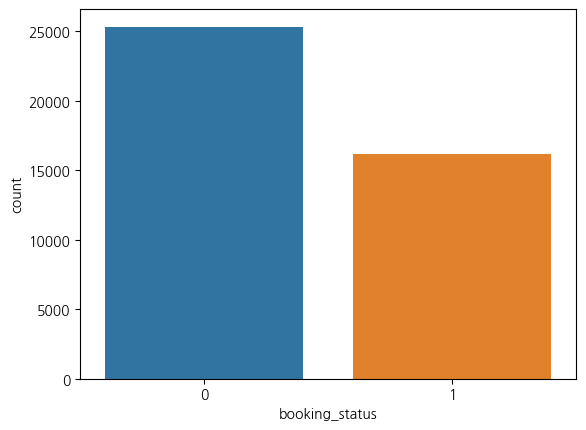

In [34]:
sns.countplot(x='booking_status', data=df_train)

### no_of_adults

성인이 0명인 데이터는 이상치인지 아닌지

<AxesSubplot:xlabel='no_of_adults', ylabel='count'>

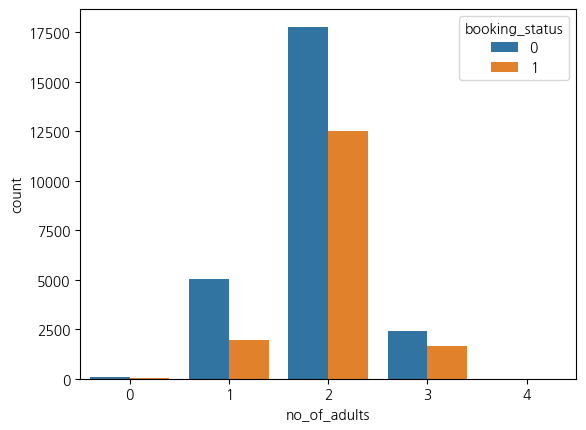

In [35]:
sns.countplot(x='no_of_adults', data=df_train, hue='booking_status')

<AxesSubplot:xlabel='no_of_adults', ylabel='count'>

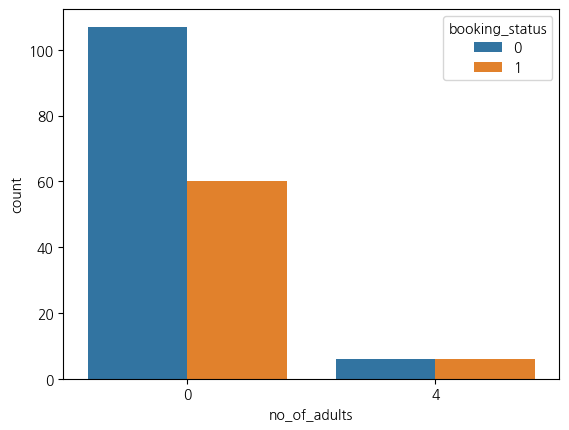

In [43]:
df_temp = df_train[df_train['no_of_adults'].isin([0,4])]
sns.countplot(x='no_of_adults', data=df_temp, hue='booking_status')

### no_of_children

<AxesSubplot:xlabel='no_of_children', ylabel='count'>

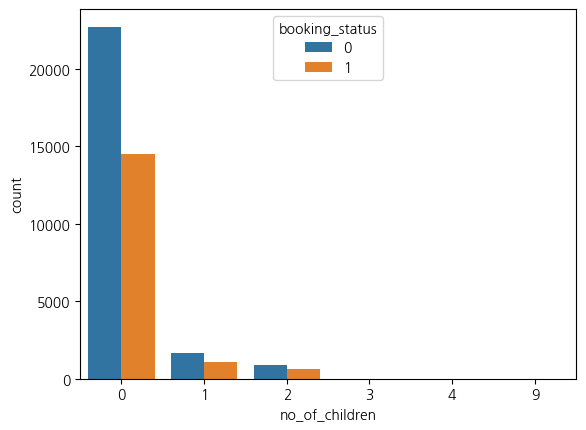

In [44]:
sns.countplot(x='no_of_children', data=df_train, hue='booking_status')

no_of_children이 3 이상인 데이터가 거의 없어서 3 이상일 경우 0이나 2로 치환

In [46]:
df_train[df_train.no_of_children.isin([3, 4, 9])]['no_of_children'].value_counts()

3    17
4     5
9     2
Name: no_of_children, dtype: int64

<AxesSubplot:xlabel='no_of_children', ylabel='count'>

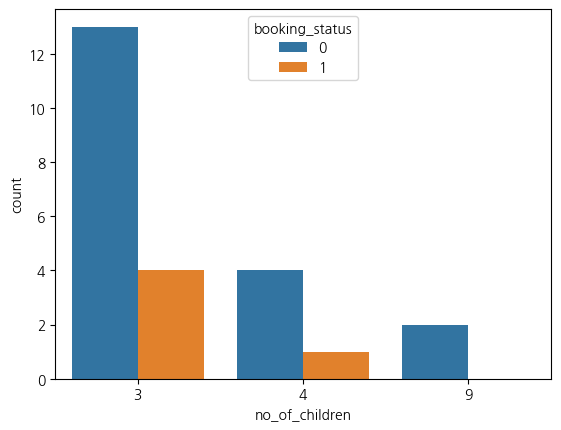

In [47]:
df_temp = df_train[df_train['no_of_children'].isin([3,4,9])]
sns.countplot(x='no_of_children', data=df_temp, hue='booking_status')

no_of_adults, no_of_children 이상치 조정

In [93]:
df_train.loc[df_train['no_of_adults']==0, 'no_of_adults'] = 1
df_train.loc[df_train['no_of_children']>=3, 'no_of_children'] = 0
df_test.loc[df_test['no_of_adults']==0, 'no_of_adults'] = 1
df_test.loc[df_test['no_of_children']>=3, 'no_of_children'] = 0

### no_of_weekend_nights

<AxesSubplot:xlabel='no_of_weekend_nights', ylabel='count'>

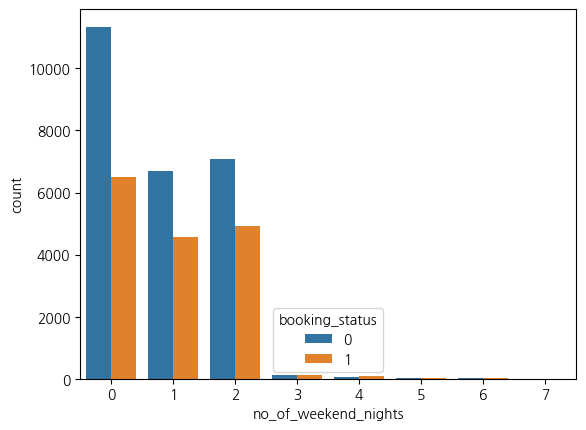

In [48]:
sns.countplot(x='no_of_weekend_nights', data=df_train, hue='booking_status')

비율상으로 주말밤이 많이 껴있을수록 booking이 될 확률이 높다

<AxesSubplot:xlabel='no_of_weekend_nights', ylabel='count'>

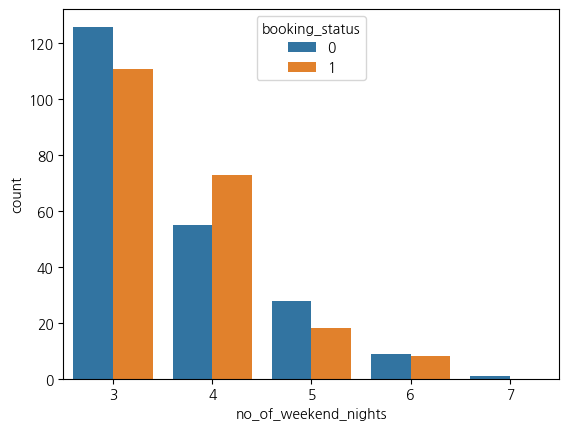

In [49]:
df_temp = df_train[df_train['no_of_weekend_nights'].isin([3,4,5,6,7])]
sns.countplot(x='no_of_weekend_nights', data=df_temp, hue='booking_status')

### no_of_week_nights

<AxesSubplot:xlabel='no_of_week_nights', ylabel='count'>

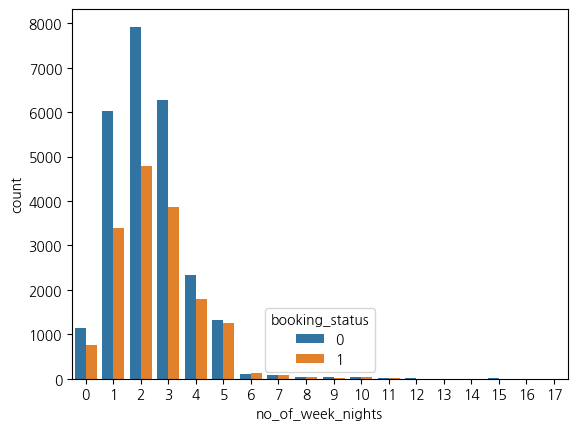

In [50]:
sns.countplot(x='no_of_week_nights', data=df_train, hue='booking_status')

<AxesSubplot:xlabel='no_of_week_nights', ylabel='count'>

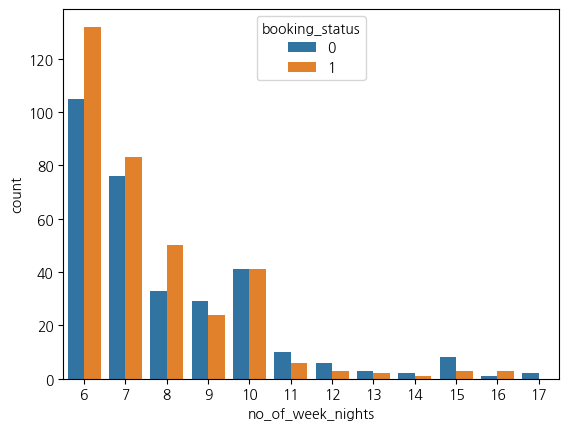

In [54]:
df_temp = df_train[df_train['no_of_week_nights']>=6]
sns.countplot(x='no_of_week_nights', data=df_temp, hue='booking_status')

no_of_weekend_nights가 높다면 no_of_week_nights도 높아야 함  
weekend_nights==3 or 4 : 5<=week_nights<=10  
weekend_nights==5 or 6 : 10<=week_nights<=15  
이상치가 있는지 확인

In [57]:
df_temp = df_train[df_train['no_of_weekend_nights'].isin([3,4])]
df_temp['no_of_week_nights'].value_counts()

5     93
7     74
6     66
10    55
9     28
8     24
11     7
3      7
4      6
12     2
2      2
15     1
Name: no_of_week_nights, dtype: int64

In [58]:
df_temp = df_train[df_train['no_of_weekend_nights'].isin([5,6])]
df_temp['no_of_week_nights'].value_counts()

10    19
11     9
15     8
12     7
13     4
16     4
2      3
3      3
14     3
17     2
1      1
Name: no_of_week_nights, dtype: int64

In [61]:
df_temp = df_train[df_train['no_of_weekend_nights'].isin([7])]
df_temp['no_of_week_nights'].value_counts()

1    1
Name: no_of_week_nights, dtype: int64

### type_of_meal_plan

<AxesSubplot:xlabel='type_of_meal_plan', ylabel='count'>

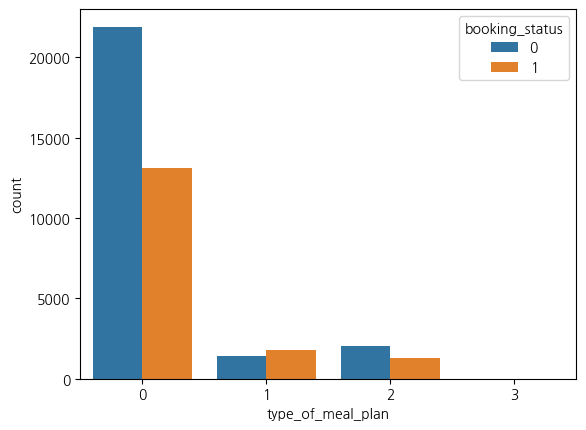

In [63]:
sns.countplot(x='type_of_meal_plan', data=df_train, hue='booking_status')

### required_car_parking_space

<AxesSubplot:xlabel='required_car_parking_space', ylabel='count'>

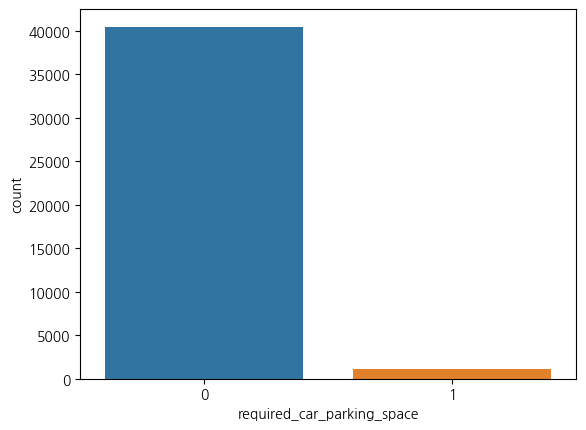

In [64]:
sns.countplot(x='required_car_parking_space', data=df_train)

In [66]:
df_train[df_train.required_car_parking_space==0].booking_status.value_counts()

0    24386
1    16090
Name: booking_status, dtype: int64

In [67]:
df_train[df_train.required_car_parking_space==1].booking_status.value_counts()

0    946
1    116
Name: booking_status, dtype: int64

 ### room_type_reserved

<AxesSubplot:xlabel='room_type_reserved', ylabel='count'>

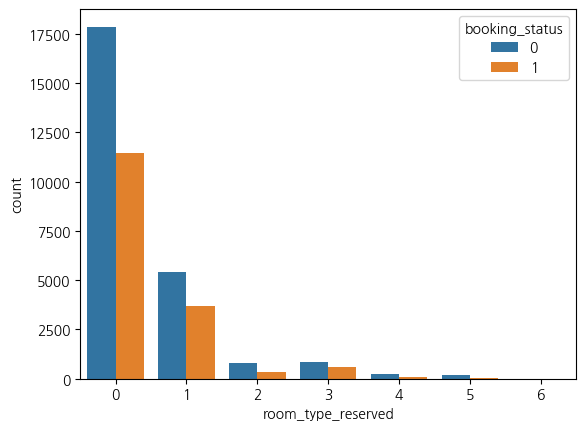

In [68]:
sns.countplot(x='room_type_reserved', data=df_train, hue='booking_status')

### lead_time

<AxesSubplot:xlabel='lead_time', ylabel='Density'>

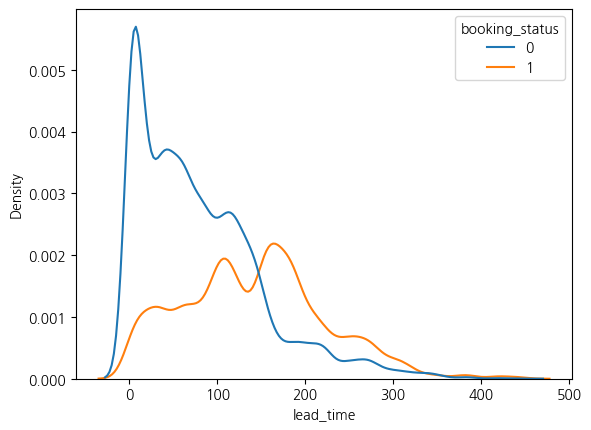

In [71]:
sns.kdeplot(x='lead_time', data=df_train, hue='booking_status')

### arrival_year, arrival_month, arrival_date

<AxesSubplot:xlabel='arrival_year', ylabel='count'>

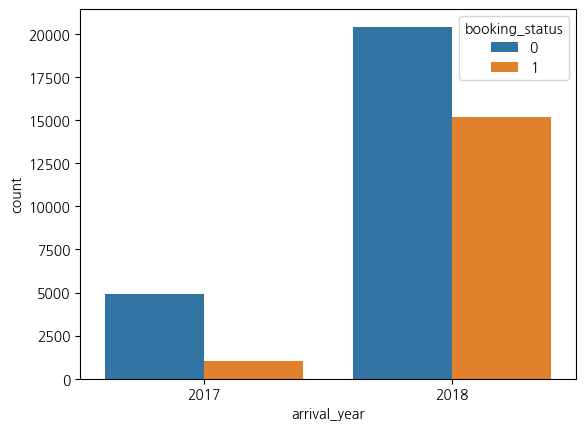

In [73]:
sns.countplot(x='arrival_year', data=df_train, hue='booking_status')

<AxesSubplot:xlabel='arrival_month', ylabel='Density'>

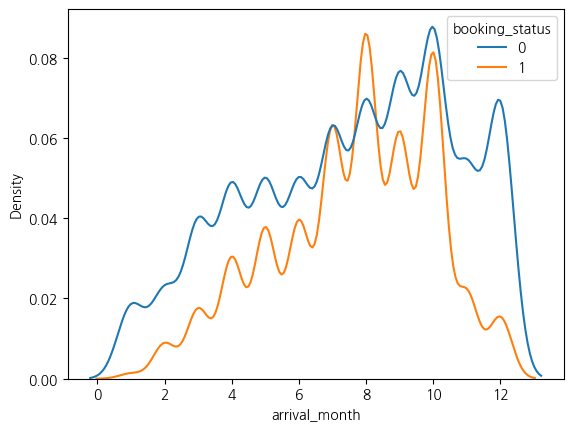

In [75]:
sns.kdeplot(x='arrival_month', data=df_train, hue='booking_status')

### market_segment_type

<AxesSubplot:xlabel='market_segment_type', ylabel='count'>

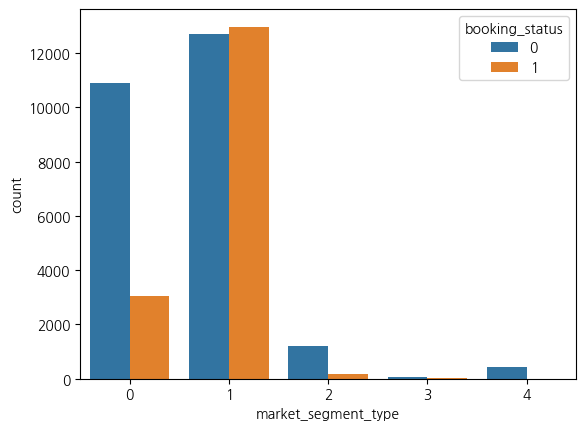

In [77]:
sns.countplot(x='market_segment_type', data=df_train, hue='booking_status')

### repeated_guest

<AxesSubplot:xlabel='repeated_guest', ylabel='count'>

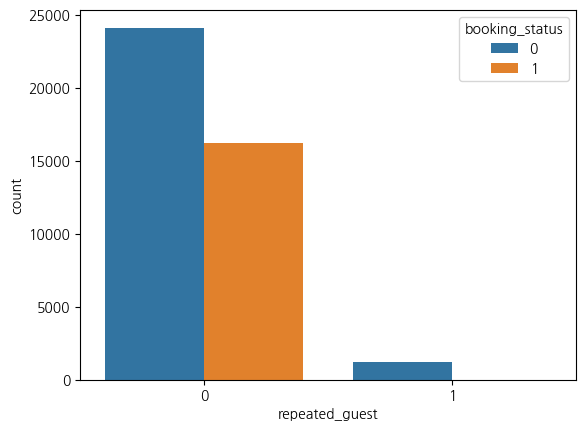

In [78]:
sns.countplot(x='repeated_guest', data=df_train, hue='booking_status')

### no_of_previous_cancellations

<AxesSubplot:xlabel='no_of_previous_cancellations', ylabel='count'>

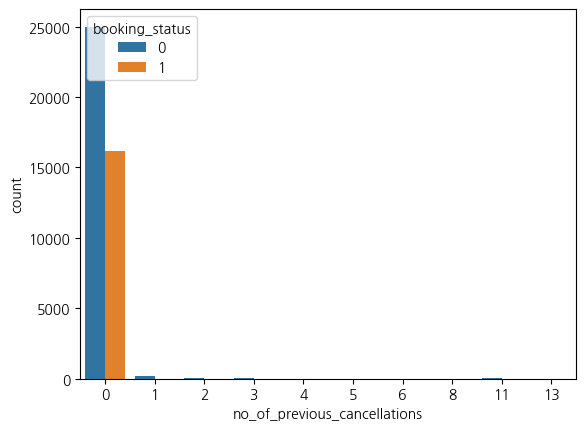

In [79]:
sns.countplot(x='no_of_previous_cancellations', data=df_train, hue='booking_status')

이전에 한번도 에약을 취소한 경험이 없는 사람들이 예약을 많이 취소함(새로운 고객?)

In [84]:
print(len(df_train[df_train.no_of_previous_cancellations==0]))
print(len(df_train[df_train.no_of_previous_cancellations>=1]))

41193
345


<AxesSubplot:xlabel='no_of_previous_cancellations', ylabel='count'>

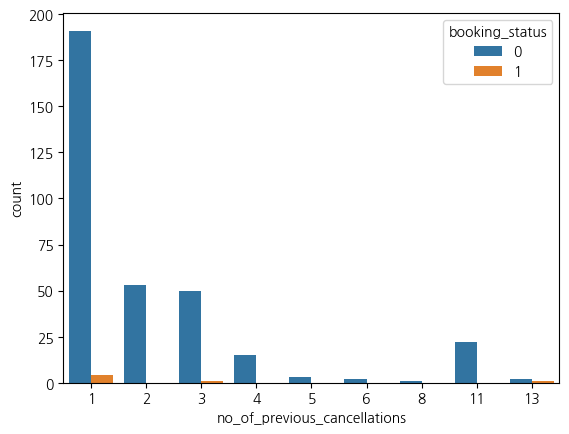

In [86]:
df_temp = df_train[df_train.no_of_previous_cancellations>=1]
sns.countplot(x='no_of_previous_cancellations', data=df_temp, hue='booking_status')

### no_of_previous_bookings_not_canceled

<AxesSubplot:xlabel='no_of_previous_bookings_not_canceled', ylabel='count'>

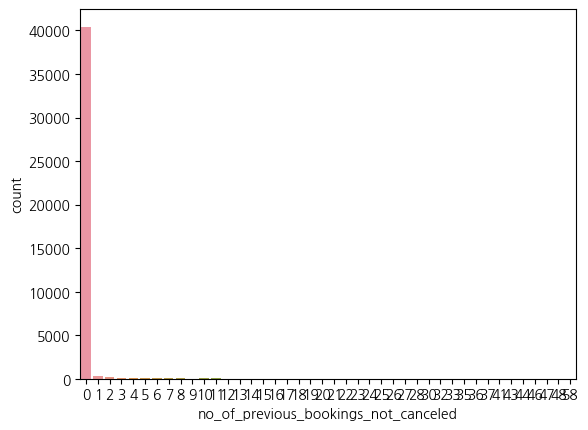

In [88]:
sns.countplot(x='no_of_previous_bookings_not_canceled', data=df_train)

In [89]:
len(df_train[df_train.no_of_previous_bookings_not_canceled!=0])

1107

### avg_price_per_room

<AxesSubplot:xlabel='avg_price_per_room', ylabel='Density'>

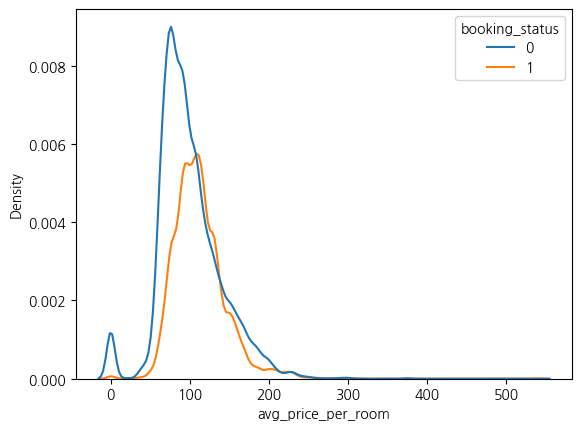

In [91]:
sns.kdeplot(x='avg_price_per_room', data=df_train, hue='booking_status')

### avg_price_per_room

# Modeling

RF feature importance 찍어보기

In [97]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
cv = StratifiedKFold(n_splits=5)

In [98]:
X, y = df_train.drop('booking_status', axis=1), df_train['booking_status']

In [113]:
scores = []

for train_index, val_index in cv.split(X, y):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model.fit(X_train, y_train)
    score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    scores.append(score)
    print(score)

print('mean', np.mean(scores))

0.8794633856340464
0.8885455720253873
0.8869777055148416
0.8924906750790826
0.8877868903080386
mean 0.8870528457122792
